---
---

# IMPORTS

In [1]:
INTERACTIVE = False
FIGWIDTH    = 12


# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
SAVEPATH  = '../Results_Lumi_V2/wires_on'

def importData(_fill,columns):
    # Importing fill data
    df = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=columns)
    df = df.sort_index()
    df.index.name = 'unix'
    df.insert(0,'Timestamp',df.index)
    df.insert(1,'Time',1e-9*(df.index - df.index[0]))
    df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))
    return df

def wireROI(df):
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
    return wire_start,wire_stop


def getFillingPatt(df):

    filled_buckets = {}
    patterns       = {}
    bunch_I        = {}
    for beam in beams:
        
        filled_ts = np.min(df[df[beam['Intensity']]== np.max(df[beam['Intensity']])].index)

        sub = df.dropna(subset=[beam['bb_Intensity']])
        _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
        
        
        bunch_I[beam.name]        =df.loc[_ts,beam['bb_Intensity']]
        filled_buckets[beam.name] = np.arange(len(buckets))[bunch_I[beam.name]!=0]
        patterns[beam.name]       = (bunch_I[beam.name]!=0)


    # Figuring out filling patterns
    patt = fp.FillingPattern(patterns['B1'], patterns['B2'])
    patt.compute_beam_beam_schedule(n_lr_per_side=21)

    for bb_patt in [patt.b1,patt.b2]:
        train_num     = np.repeat(np.arange(len(bb_patt.train_lengths)),bb_patt.train_lengths)
        train_lengths = np.repeat(bb_patt.train_lengths,bb_patt.train_lengths)
        bb_patt.bb_schedule.insert(0,'Train',train_num)
        bb_patt.bb_schedule.insert(1,'Train Lengths',train_lengths)
        bb_patt.bb_schedule.insert(2,'Tag',None)


        targetTrain = bb_patt.bb_schedule['Train Lengths'].max()

        grouped = bb_patt.bb_schedule.groupby('Train')
        for train in list(grouped.groups.keys()):
            if grouped.get_group(train)['Train Lengths'].max() == targetTrain:
                _first  = grouped.get_group(train).index[0]
                _middle = grouped.get_group(train).index[targetTrain//2]

                bb_patt.bb_schedule.loc[_first,'Tag']  = 'first'
                bb_patt.bb_schedule.loc[_middle,'Tag'] = 'middle'

    return patt


2022-09-15 20:57:25,454 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



# Import single fill

In [2]:

FILL = 8128


# Importing some data for timescales
#-----------------------------------
database             = importData(FILL,columns=['HX:BMODE']+[wire.I for wire in wires['B1']+wires['B2']] + [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams])
wire_start,wire_stop = wireROI(database)
start_ts             = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
stop_ts              = wire_start+pd.Timedelta(hours=2)
patt                 = getFillingPatt(database) 
#-----------------------------------

# Loading effective cross section df
#-----------------------------------
xsection_df = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]        = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_F{FILL}_{beam.name}.pkl")
    xsection_smooth_df[beam.name] = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_smooth_F{FILL}_{beam.name}.pkl")
#-----------------------------------



Computing collision schedules...
Done Beam 1
Done Beam 2


# Mountain Range Plot

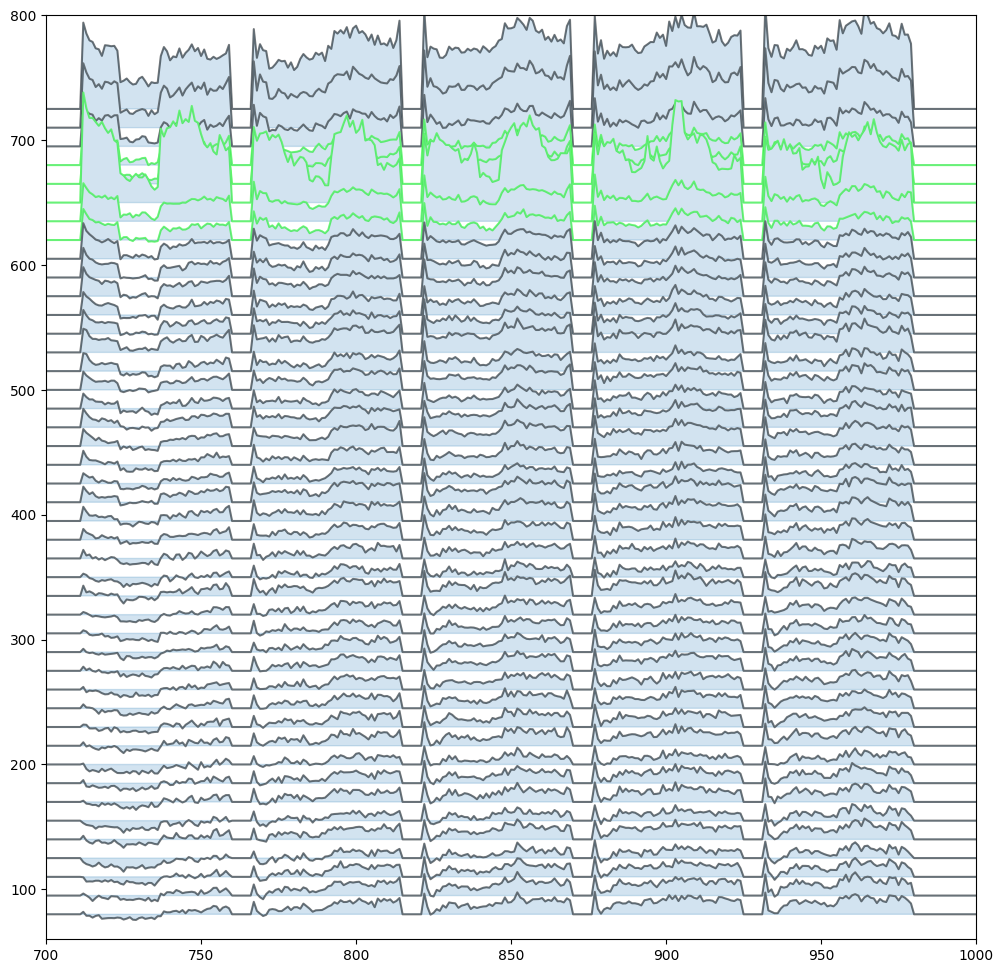

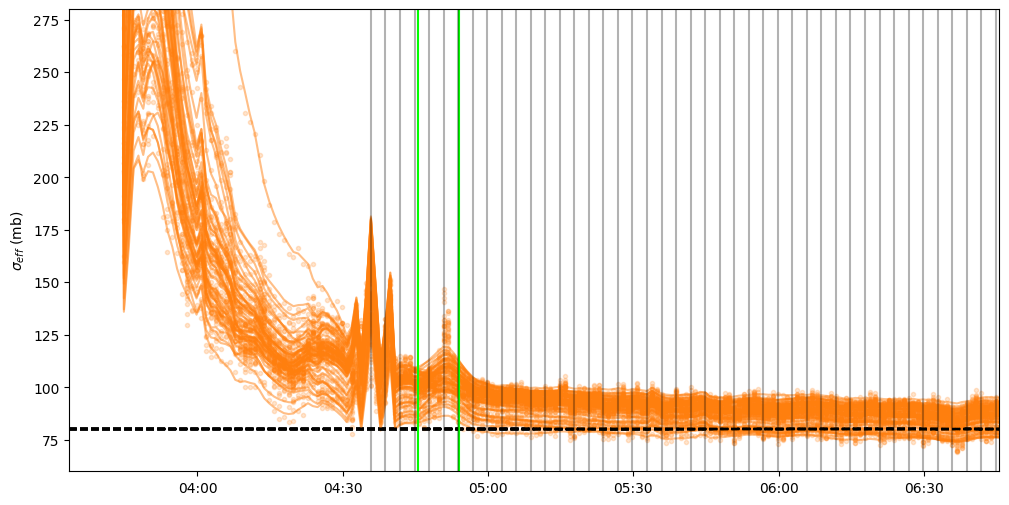

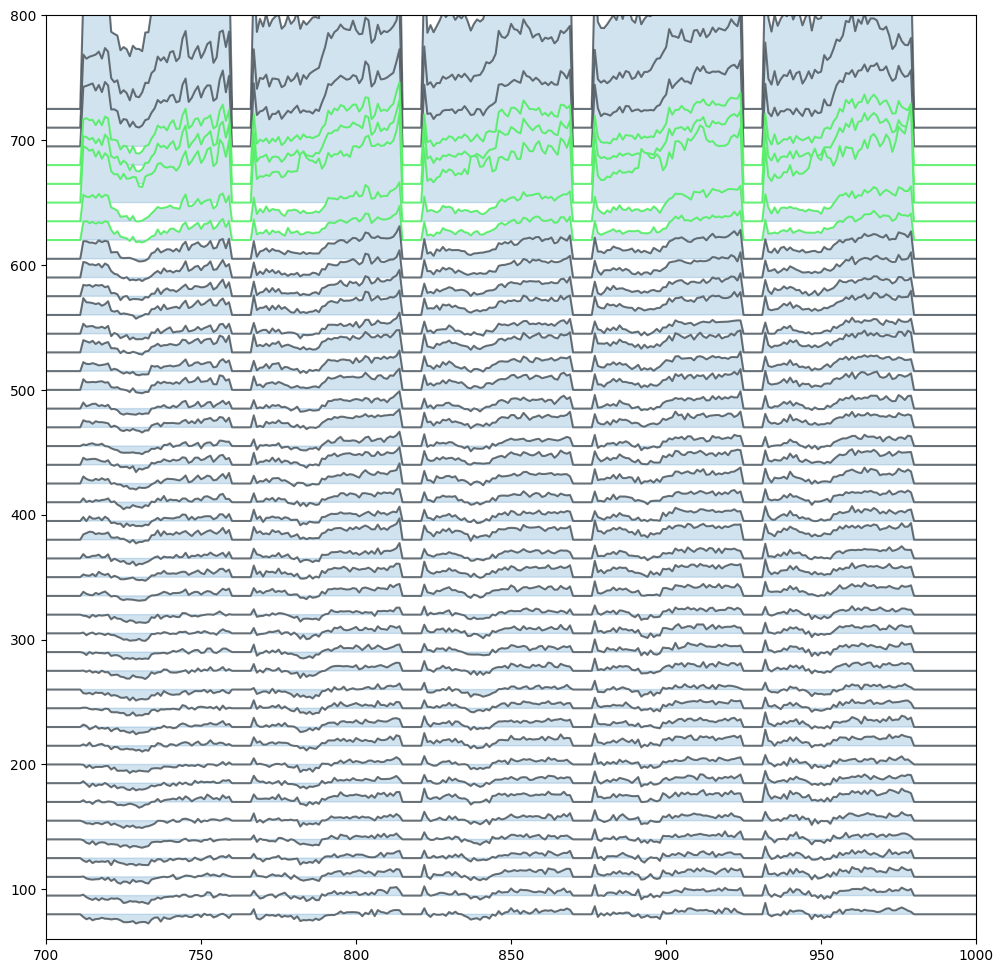

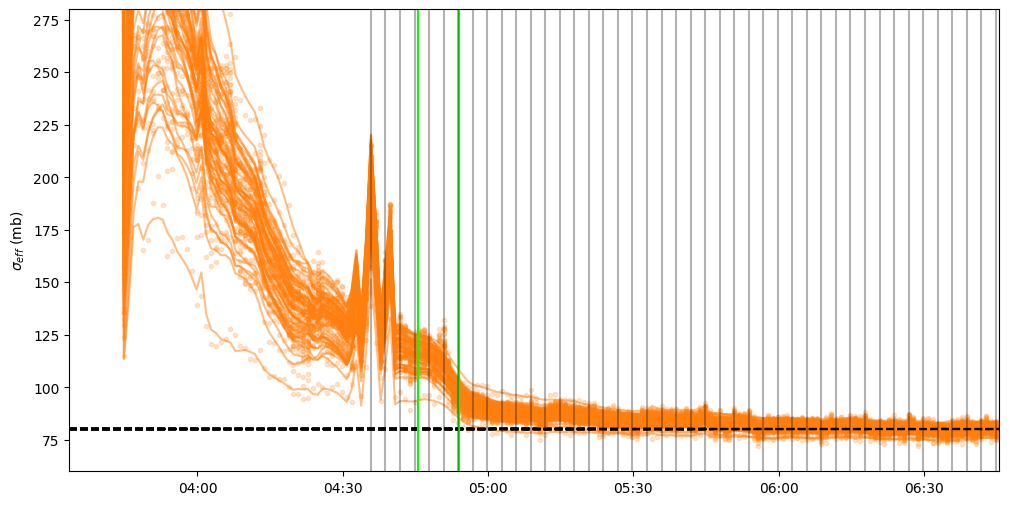

In [3]:



plt.close('all')
for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
 

    # This is sampled minute by minute
    start_ts   = wire_start-pd.Timedelta(minutes=12)
    observable = xsection_df[beam.name].set_index('Timestamp').loc[start_ts:stop_ts]['sig_eff'].dropna()
    obs_ts     = observable.index[::-3]
    #obs_ts     = observable.index[-3*60:-1:10]

    
    start_green = np.sort(obs_ts)[np.sort(obs_ts)<wire_start][-1]
    stop_green  = np.sort(obs_ts)[np.sort(obs_ts)>wire_stop][0] 

    plt.figure(figsize=(FIGWIDTH,12))
    for jump_idx,idx in enumerate(obs_ts):

        time_gap          = np.abs(np.mean(np.diff(obs_ts))).seconds/60
        baseline          = 5*time_gap*jump_idx + 80
        line              = np.nan*np.ones(len(buckets))
        line              = baseline*np.ones(len(buckets))
        line[bb_df.index] = observable.loc[idx][bb_df.index]/1e-3-80 + baseline

        zorder = -baseline
        if (idx>=start_green)&(idx<=stop_green):
            plt.plot(buckets,line,'-',color='lime',alpha=0.5,zorder=zorder+3)
        else:
            plt.plot(buckets,line,'-',color='k',alpha=0.5,zorder=zorder+3)
        plt.fill_between(buckets,baseline,line,color='w',alpha=1,zorder=zorder+1)
        plt.fill_between(buckets,baseline,line,color='C0',alpha=0.2,zorder=zorder+2)
        #plt.fill_between(buckets,baseline,line,color='w',alpha=1)

    plt.ylim([60,800])#,np.max(line[line<1000])])
    #plt.xlim([50,1000])
    plt.xlim([700,1000])
    #plt.xlim([1000,1300])


    plt.figure(f'Time Evol.,{beam.name}',figsize=(FIGWIDTH,6))
    middles =  bb_df.groupby('Tag').get_group('middle').index
    for tagged,info,color in zip([middles],['middle'],['C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)
            plt.axhline(80,ls='--',color='k')
            plt.ylim([60,280])
            plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    for ts in obs_ts:
        plt.axvline(ts,color='k',alpha=0.3)
    #plt.axvline(beta_reached,color='red')

    ax2_start = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    plt.xlim([start_ts-pd.Timedelta(minutes=60),stop_ts])


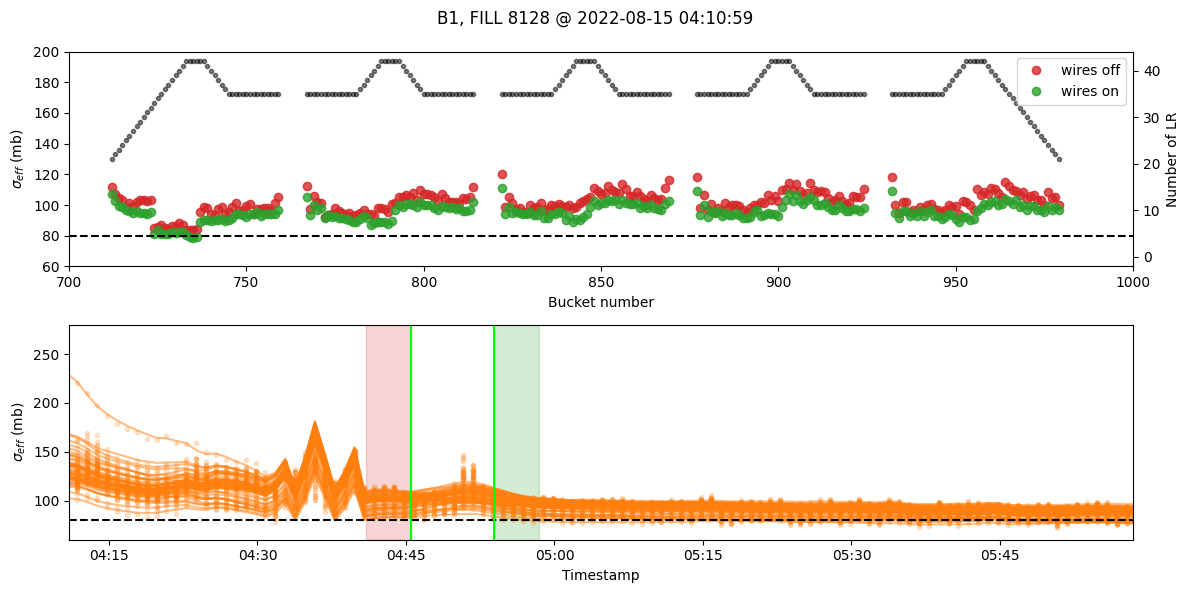

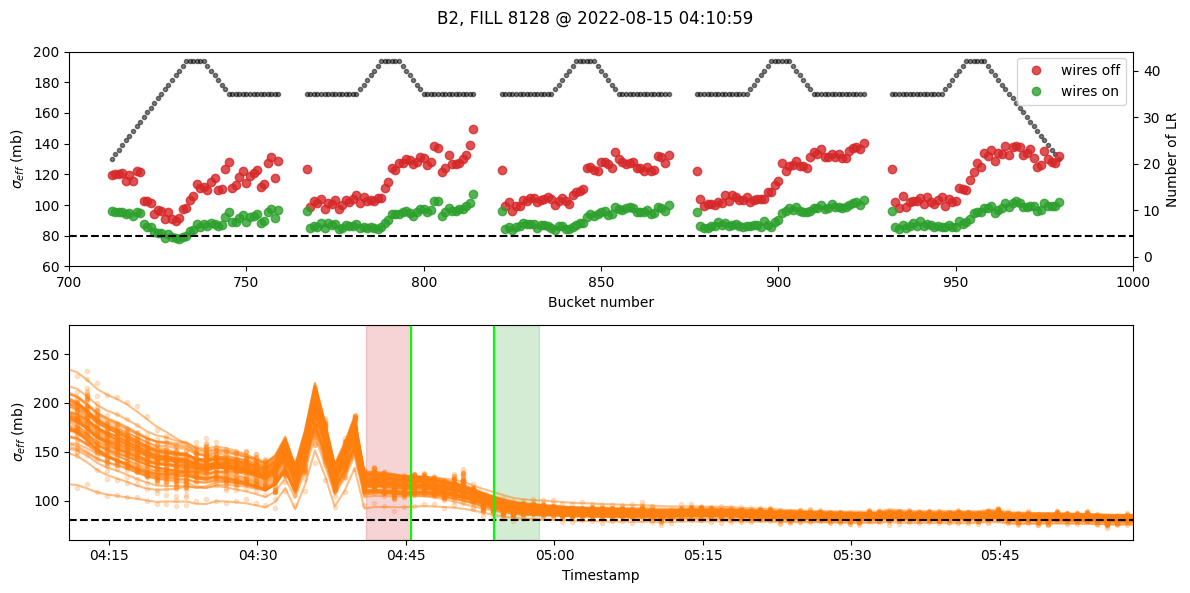

In [20]:


t0 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=30)
t1 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=15)
t2 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=15)
t3 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=30)


#start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]

t0 = wire_start - pd.Timedelta(minutes=4.5)
t1 = wire_start
t2 = wire_stop
t3 = t2 + (t1-t0)











for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
    
    fig, axes = plt.subplots(figsize=(12,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
   
    
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    LRcount = np.nan*np.zeros(len(buckets))
    LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']

    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',alpha=0.8,color='C3',label='wires off')
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3 ,'o',alpha=0.8,color='C2',label='wires on')
    plt.axhline(80,ls='--',color='k')
    plt.legend()
    plt.ylim([60,200])
    plt.xlim([700,1000])
    #plt.xlim([2700,3200])

    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    plt.plot(buckets,LRcount,'.k',alpha=0.5,zorder=-10)
    plt.ylabel(r'Number of LR')


    plt.sca(axes[1])

    middles =  bb_df.groupby('Tag').get_group('middle').index
    for tagged,info,color in zip([middles],['middle'],['C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)
    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform())
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform())

    plt.ylim([60,280])
    plt.xlim([t0-pd.Timedelta(minutes=30),t3+pd.Timedelta(minutes=60)])
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')

    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(t0-pd.Timedelta(minutes=30))[:19]}')
    plt.tight_layout()
    
    



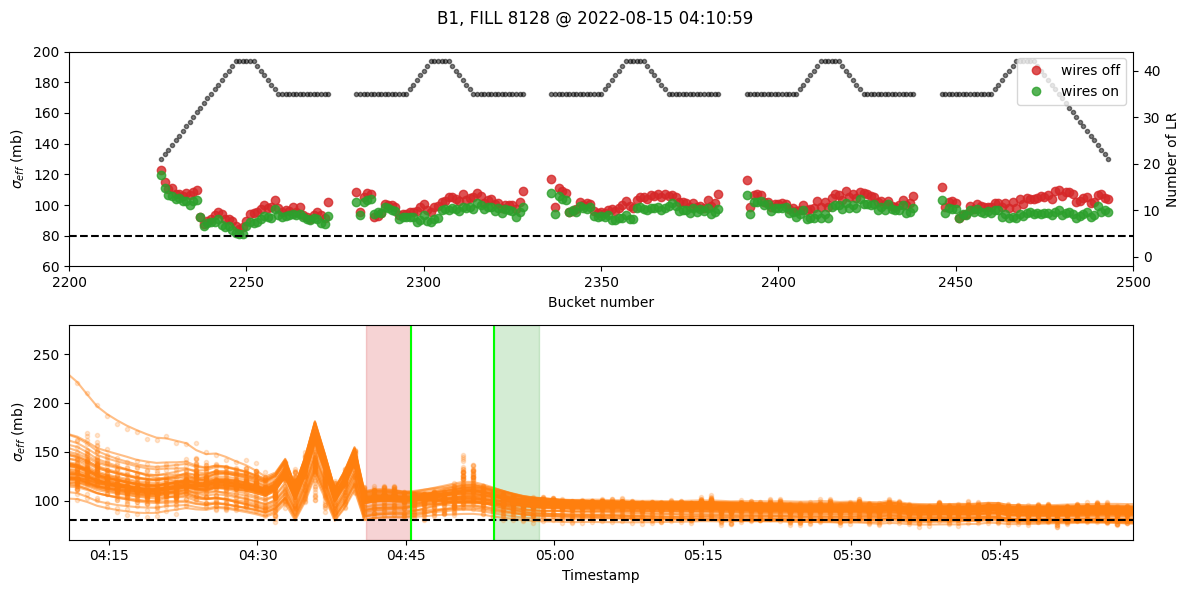

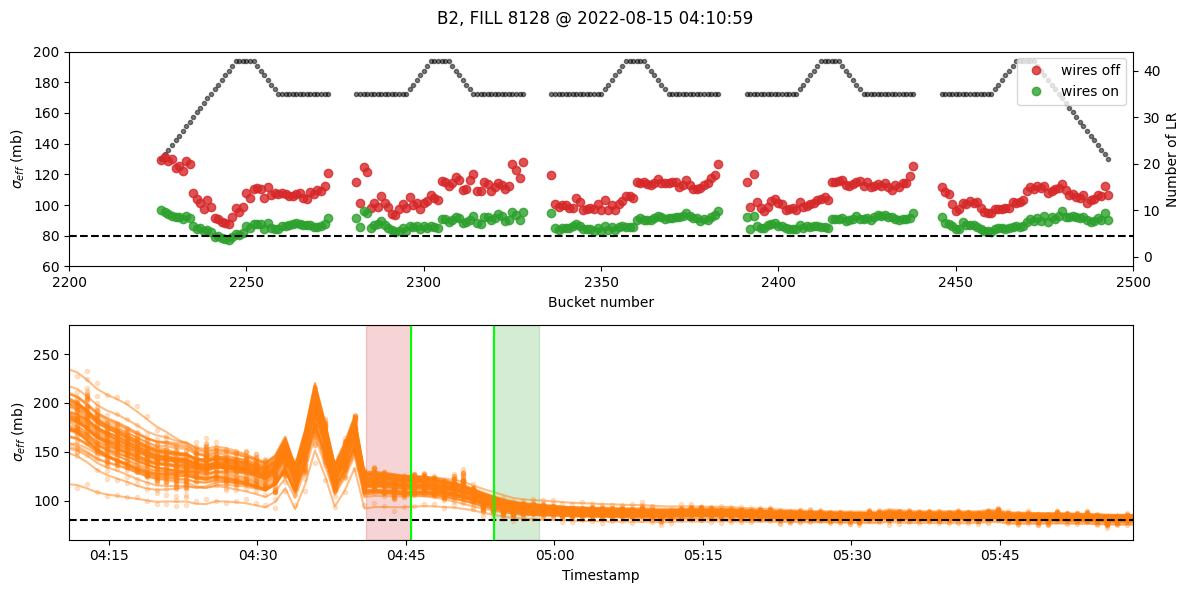

In [25]:


t0 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=30)
t1 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=15)
t2 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=15)
t3 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=30)


#start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]

t0 = wire_start - pd.Timedelta(minutes=4.5)
t1 = wire_start
t2 = wire_stop
t3 = t2 + (t1-t0)











for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
    
    fig, axes = plt.subplots(figsize=(12,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
   
    
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    LRcount = np.nan*np.zeros(len(buckets))
    LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']

    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',alpha=0.8,color='C3',label='wires off')
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3 ,'o',alpha=0.8,color='C2',label='wires on')
    plt.axhline(80,ls='--',color='k')
    plt.legend()
    plt.ylim([60,200])
    #plt.xlim([1300,1600])
    plt.xlim([2200,2500])

    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    plt.plot(buckets,LRcount,'.k',alpha=0.5,zorder=-10)
    plt.ylabel(r'Number of LR')


    plt.sca(axes[1])

    middles =  bb_df.groupby('Tag').get_group('middle').index
    for tagged,info,color in zip([middles],['middle'],['C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)
    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform())
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform())

    plt.ylim([60,280])
    plt.xlim([t0-pd.Timedelta(minutes=30),t3+pd.Timedelta(minutes=60)])
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')

    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(t0-pd.Timedelta(minutes=30))[:19]}')
    plt.tight_layout()
    
    



In [5]:
%matplotlib inline

In [6]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


(50.0, 1000.0)

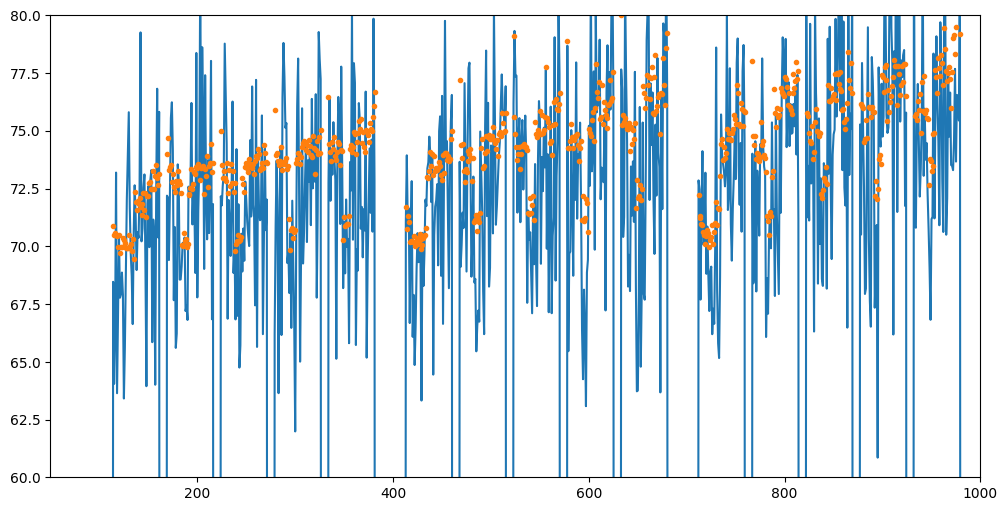

In [ ]:
ts              = xsection_df[beam.name]['Timestamp']
xsection        = xsection_df[beam.name]['sig_eff']
xsection_smooth = xsection_smooth_df[beam.name]['sig_eff']


plt.figure(figsize=(FIGWIDTH,6))
plt.plot(xsection.iloc[-1]/1e-3,'-')
plt.plot(xsection_smooth.iloc[-1]/1e-3,'.')
plt.ylim([60,80])
plt.xlim([50,1000])

# Axel Plot

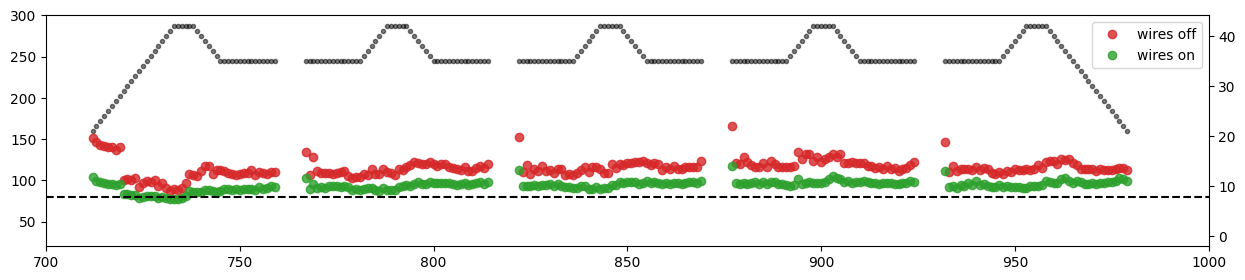

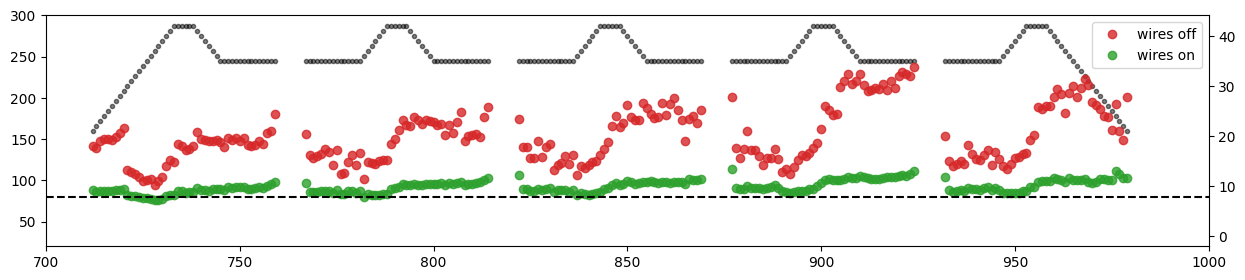

In [ ]:


t0 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=30)
t1 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=15)
t2 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=15)
t3 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=30)

for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    LRcount = np.nan*np.zeros(len(buckets))
    LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']

    plt.figure(figsize=(15,3))
    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',alpha=0.8,color='C3',label='wires off')
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3 ,'o',alpha=0.8,color='C2',label='wires on')
    plt.axhline(80,ls='--',color='k')
    plt.legend()
    plt.ylim([20,300])
    plt.xlim([700,1000])

    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    
    plt.plot(buckets,LRcount,'.k',alpha=0.5,zorder=-10)




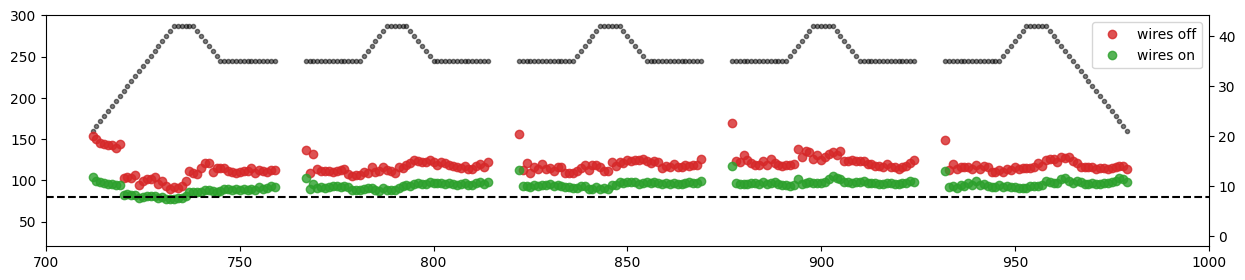

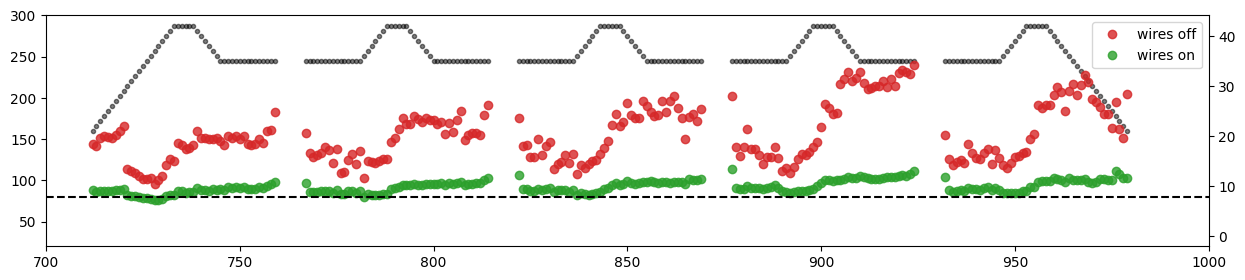

In [ ]:


t0 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=30)
t1 = wire_stop-pd.Timedelta(minutes=3)-pd.Timedelta(minutes=15)
t2 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=15)
t3 = wire_stop-pd.Timedelta(minutes=3)+pd.Timedelta(minutes=30)

for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):
    ROI_Before = xsection_smooth_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_smooth_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    LRcount = np.nan*np.zeros(len(buckets))
    LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']

    plt.figure(figsize=(15,3))
    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',alpha=0.8,color='C3',label='wires off')
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3 ,'o',alpha=0.8,color='C2',label='wires on')
    plt.axhline(80,ls='--',color='k')
    plt.legend()
    plt.ylim([20,300])
    plt.xlim([700,1000])

    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    
    plt.plot(buckets,LRcount,'.k',alpha=0.5,zorder=-10)


